In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
ticker='NVDA'
market='SPY'
start='2015-01-01'
end='2026-01-01'
interval='1mo'

In [3]:
def get_data(tick: str = None, market: str = None, startdate: str = None, enddate: str = None, interv=None, adjusted: bool = True):

    """Collect stocks values from Yahoo Finance and compute daily returns."""

    if tick is None:
        tick = input("Enter the ticker (e.g. AAPL): ").strip()
    if market is None:
        market = input("Enter the market (e.g. SPY): ").strip()
    if startdate is None:
        startdate = input("Enter the start date (YYYY-MM-DD): ").strip()
    if enddate is None:
        enddate = input("Enter the end date (YYYY-MM-DD): ").strip()
    if interv is None:
        interv = '1d'

    df = pd.DataFrame()

    stock_data = yf.download(tick, start=startdate, end=enddate, interval=interv, progress=False)
    if stock_data.empty:
        raise ValueError(f"No data retrieved for ticker '{tick}'")

    df[f'{tick}_Close'] = stock_data['Close']
    df[f'{tick}_r'] = stock_data['Close'].pct_change()

    market_data = yf.download(market, start=startdate, end=enddate, interval=interv, progress=False)
    if market_data.empty:
        raise ValueError(f"No data retrieved for market '{market}'")

    df[f'{market}_Close'] = market_data['Close']
    df[f'market_r'] = market_data['Close'].pct_change()

    volatility = yf.download('^VIX', start=startdate, end=enddate, interval=interv, progress=False)
    volatility.columns.name=None
    volatility.columns = volatility.columns.get_level_values(0)

    df['VIX']=volatility['Close']

    return df,volatility


df,vol=get_data(tick=ticker, market=market, startdate=start, enddate=end, interv=interval)

df

/tmp/ipython-input-3851117329.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tick, start=startdate, end=enddate, interval=interv, progress=False)
/tmp/ipython-input-3851117329.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(market, start=startdate, end=enddate, interval=interv, progress=False)
/tmp/ipython-input-3851117329.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  volatility = yf.download('^VIX', start=startdate, end=enddate, interval=interv, progress=False)


,NVDA_Close,NVDA_r,SPY_Close,market_r,VIX
Date,,,,,
2015-01-01,0.460696,NaN,165.623795,NaN,20.969999
2015-02-01,0.529321,0.148959,174.932617,0.056205,13.340000
2015-03-01,0.504141,-0.047571,171.419998,-0.020080,15.290000
2015-04-01,0.534731,0.060678,173.878479,0.014342,14.550000
2015-05-01,0.533045,-0.003153,176.113876,0.012856,13.840000
...,...,...,...,...,...
2025-08-01,174.160477,-0.020746,641.371399,0.020520,15.360000
2025-09-01,186.559097,0.071191,662.380859,0.032757,16.280001
2025-10-01,202.478729,0.085333,680.050537,0.026676,17.440001


In [4]:
 def risk_free_rate(df,startdate,enddate,interv):

  """ Import and treat data to calculate real risk free rate based on 10Y Treasury Bonds  """

  nominal_rfr=pd.DataFrame(
      yf.download(
        tickers='^TNX',
        start=startdate,
        end=enddate,
        progress=False
        ))['Close']

  if interv=='1mo':
    rsmpl_interv='ME'
  elif interv=='1wk':
    rsmpl_interv='WE'

  nominal_rfr.columns.name=None
  nominal_rfr=nominal_rfr.resample(rsmpl_interv).last()

  inflation_start = pd.to_datetime(startdate) - pd.DateOffset(years=1)
  inflation = pdr.get_data_fred('CPIAUCSL', inflation_start, enddate).pct_change(12).dropna()
  inflation.index= inflation.index + pd.offsets.MonthEnd(0)
  inflation.columns.name=None

  real_rfr=pd.DataFrame()
  real_rfr['nominal_rfr']=nominal_rfr/100
  real_rfr['inflation']=inflation
  real_rfr['real_rfr']=(1+real_rfr['nominal_rfr'])/(1+real_rfr['inflation'])-1


  return real_rfr.reindex(df.index,method='ffill')

real_rfr=risk_free_rate(df=df,startdate=start,enddate=end,interv=interval)

real_rfr

/tmp/ipython-input-3925621939.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(
/tmp/ipython-input-3925621939.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation = pdr.get_data_fred('CPIAUCSL', inflation_start, enddate).pct_change(12).dropna()


,nominal_rfr,inflation,real_rfr
Date,,,
2015-01-01,NaN,NaN,NaN
2015-02-01,0.01675,-0.002299,0.019093
2015-03-01,0.02002,-0.000870,0.020909
2015-04-01,0.01934,-0.000220,0.019565
2015-05-01,0.02046,-0.001040,0.021523
...,...,...,...
2025-08-01,0.04360,0.027318,0.015849
2025-09-01,0.04227,0.029392,0.012510
2025-10-01,0.04148,0.030227,0.010923


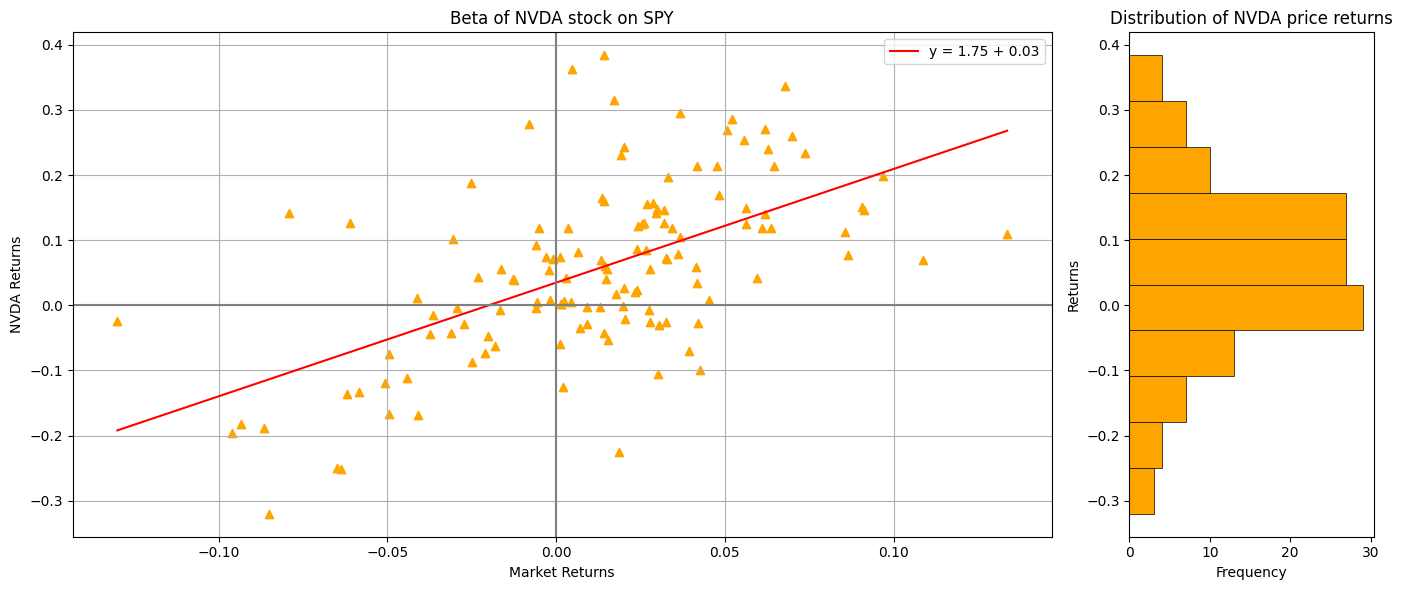

np.float64(1.7456780294300245)

In [5]:
def beta(df,tick):

  """ This function computes the beta of a stock returns based on market returns and plots the linear regression. It measures the covariance between both returns"""

  df_clean=df.dropna()
  poly = np.polyfit(x=df_clean[f'market_r'], y=df_clean[f'{tick}_r'], deg=1)
  beta = poly[0]
  poly1=np.poly1d(poly)

  beta_xline=np.linspace(df_clean[f'market_r'].min(),df_clean[f'market_r'].max(),100)
  beta_yline=poly1(beta_xline)

  fig1,(ax1,ax2)= plt.subplots(1,2,figsize=(14,6),gridspec_kw={'width_ratios': [4, 1]})

  beta_function=f"y = {beta:.2f} + {poly[1]:.2f}"

  ax1.scatter(x=df_clean[f'market_r'],y=df_clean[f'{tick}_r'],color='orange',marker='^')
  ax1.plot(beta_xline,beta_yline,color='red',label=beta_function)
  ax1.axvline(0, color='grey', alpha = 1)
  ax1.axhline(0, color='grey', alpha = 1)
  ax1.set_title(f'Beta of {tick} stock on {market}')
  ax1.set_xlabel('Market Returns')
  ax1.set_ylabel(f'{tick} Returns')
  ax1.legend()
  ax1.grid(True)

  ax2.hist(x=df_clean[f'{tick}_r'],orientation='horizontal',linewidth=0.5,color='orange',edgecolor='black')
  ax2.set_title(f'Distribution of {tick} price returns')
  ax2.set_xlabel("Frequency")
  ax2.set_ylabel("Returns")

  plt.style.use('dark_background')
  plt.tight_layout()
  plt.show()


  return beta

beta=beta(df=df,tick=ticker)
beta







In [6]:
def equity_risk_premium(df,real_rfr):

  """ Calculates the Equity Risk Premium """

  eqrp=pd.DataFrame()
  eqrp['ERP']=df['market_r']-real_rfr['real_rfr']

  return eqrp

eqrp=equity_risk_premium(df,real_rfr)
eqrp

,ERP
Date,
2015-01-01,NaN
2015-02-01,0.037111
2015-03-01,-0.040988
2015-04-01,-0.005223
2015-05-01,-0.008667
...,...
2025-08-01,0.004671
2025-09-01,0.020247
2025-10-01,0.015753


In [7]:
def capm(real_rfr,beta,df,eqrp):

  """This function computes the cost of equity based on the Capital Asset Pricing Model """

  coe=pd.DataFrame(index=df.index)
  coe['COE']=real_rfr['real_rfr']+beta*eqrp['ERP']

  return coe
coe=capm(real_rfr,beta,df,eqrp)
df['COE']=coe
coe

,COE
Date,
2015-01-01,NaN
2015-02-01,0.083878
2015-03-01,-0.050644
2015-04-01,0.010447
2015-05-01,0.006394
...,...
2025-08-01,0.024002
2025-09-01,0.047855
2025-10-01,0.038423


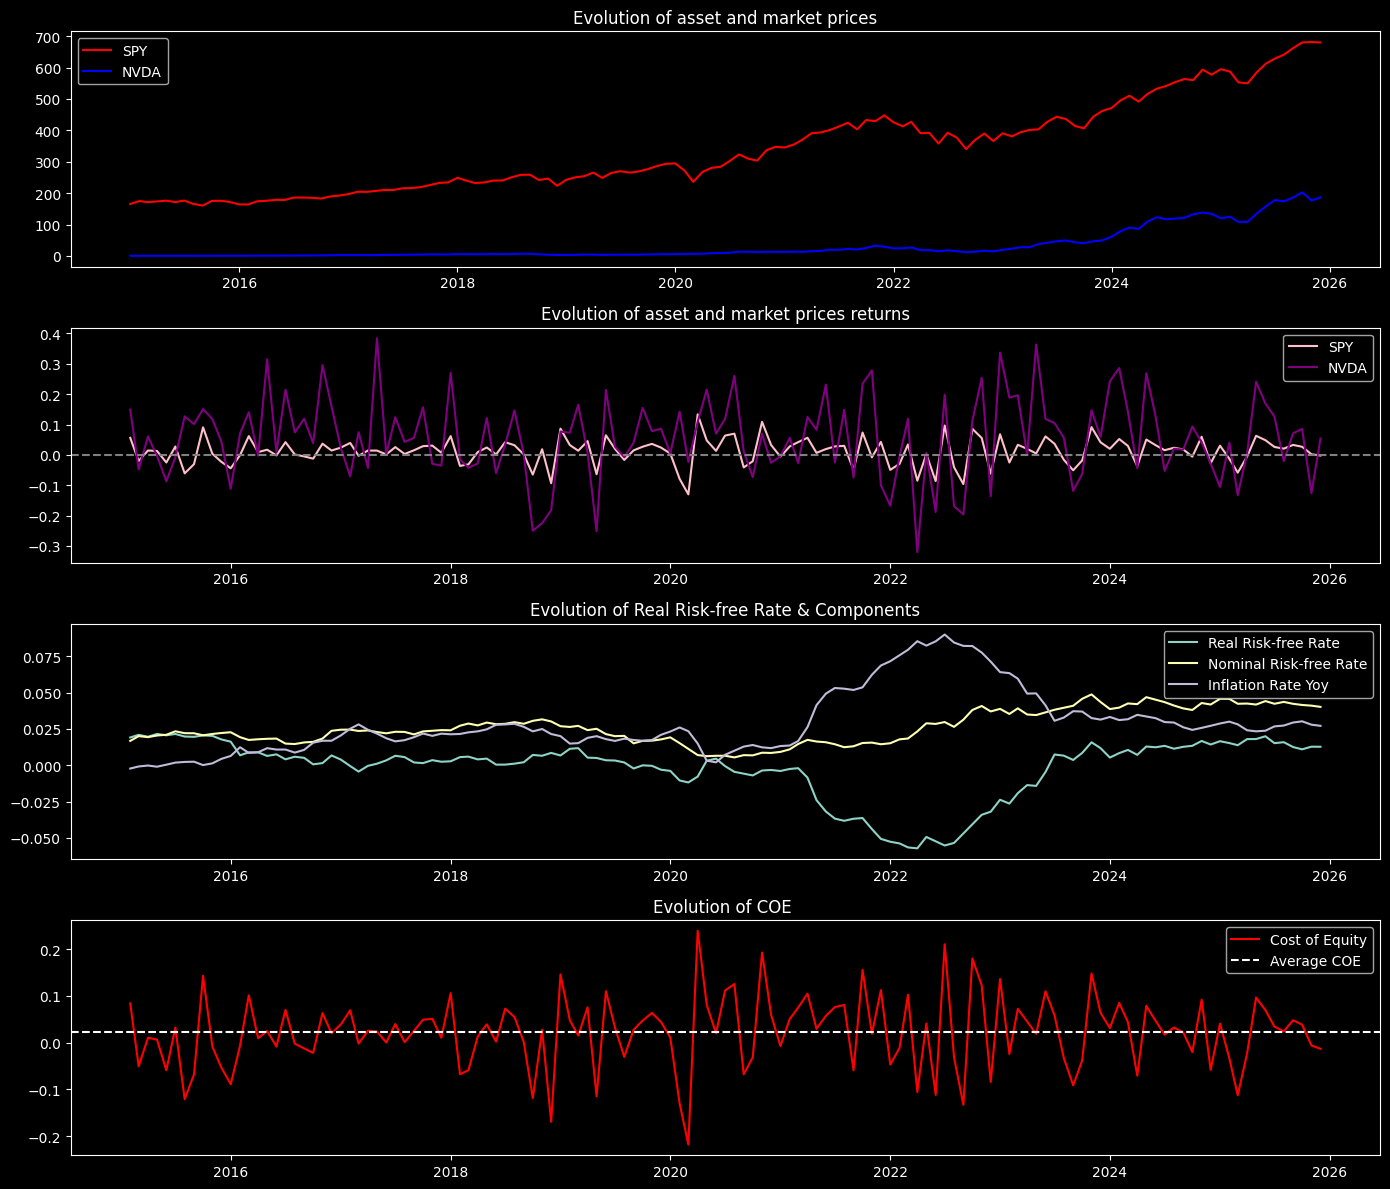

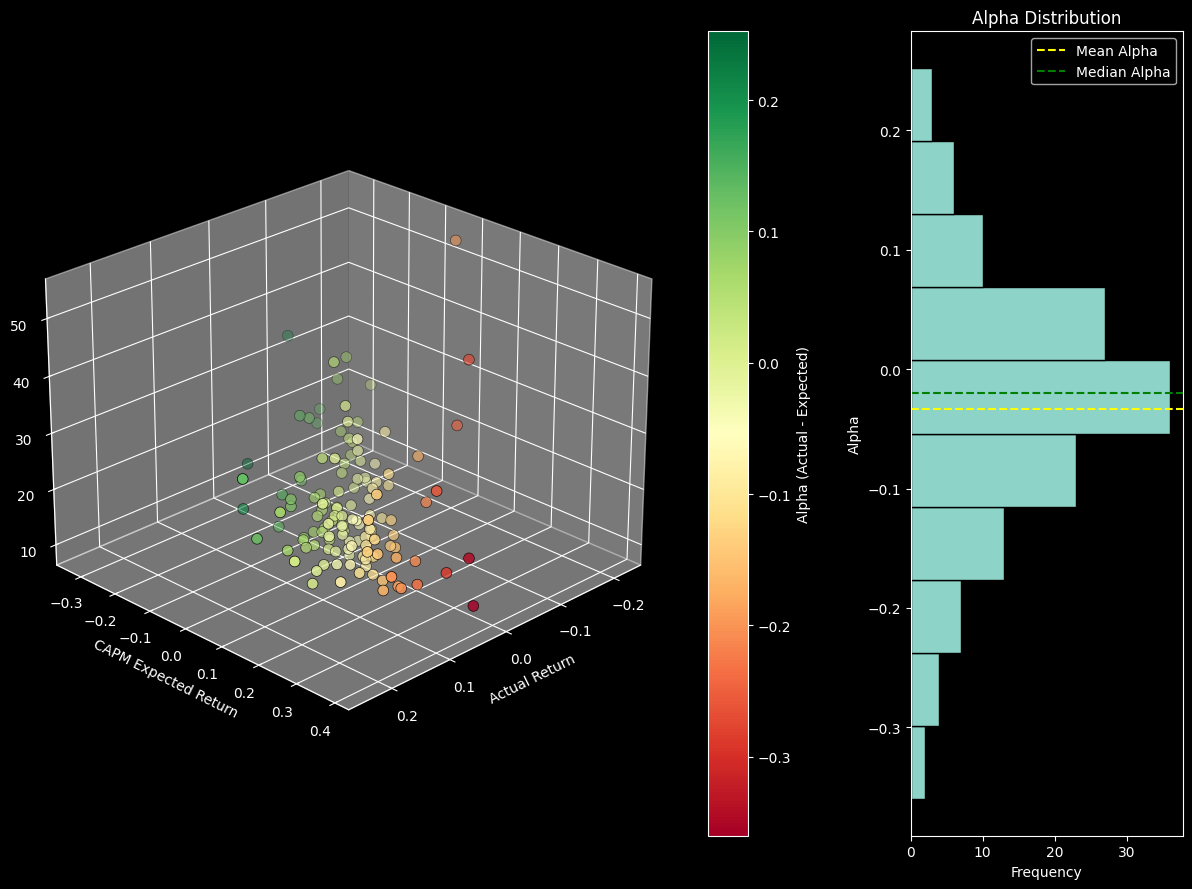

In [8]:
from matplotlib.lines import lineStyles
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

class plot_results():

  # FIGURE 1 : TIME SERIES DASHBOARD

  fig, axes = plt.subplots(4,1,figsize=(14,12))

  #Prices
  axes[0].plot(df[f'{market}_Close'],label=market,color='red')
  axes[0].plot(df[f'{ticker}_Close'],label=ticker,color='blue')
  axes[0].set_title("Evolution of asset and market prices")
  axes[0].legend()

  #Returns
  axes[1].plot(df[f'market_r'],label=market,color='pink')
  axes[1].plot(df[f'{ticker}_r'],label=ticker,color='purple')
  axes[1].set_title("Evolution of asset and market prices returns")
  axes[1].axhline(y=0, color='gray', linestyle='--')
  axes[1].legend()

  #Risk-Free Rates
  axes[2].plot(real_rfr['real_rfr'],label='Real Risk-free Rate')
  axes[2].plot(real_rfr['nominal_rfr'],label='Nominal Risk-free Rate')
  axes[2].plot(real_rfr['inflation'],label='Inflation Rate Yoy')
  axes[2].set_title("Evolution of Real Risk-free Rate & Components")
  axes[2].legend()

  #Cost of Equity
  axes[3].plot(coe.index, coe['COE'], label='Cost of Equity', color='red')
  axes[3].axhline(y=coe['COE'].mean(), linestyle='--', label='Average COE')
  axes[3].set_title("Evolution of COE ")
  axes[3].legend()

  plt.tight_layout()
  plt.show()

  # FIGURE 2 : CAPM BACKTEST

  def plot_capm_backtest(df,ticker):

    """Plot CAPM Backtest Results to Evaluate the Model's accuracy"""

    fig = plt.figure(figsize=(12,9))
    gs = GridSpec(1, 2, width_ratios=[3, 1])

    axe0 = fig.add_subplot(gs[0, 0], projection='3d')
    axe1 = fig.add_subplot(gs[0, 1])

    expected=df['COE'].dropna()
    actual=df[f'{ticker}_r'].dropna()
    volatility=df['VIX'].reindex_like(actual)
    alpha=expected-actual

    #Backtest Results and Alpha
    scatter = axe0.scatter(expected,actual,volatility, c=alpha, cmap='RdYlGn',edgecolor='black',s=60,linewidths=0.5)
    axe0.view_init(elev=25, azim=45)

    fig.colorbar(scatter, ax=axe0, label='Alpha (Actual - Expected)', pad=0.05)

    axe0.set_xlabel('Actual Return')
    axe0.set_ylabel('CAPM Expected Return')
    axe0.set_zlabel('Volatility')

    #Alpha Distribution
    axe1.hist(x=alpha,orientation='horizontal', edgecolor='black')
    axe1.axhline(alpha.mean(), label='Mean Alpha', linestyle='--', color='yellow')
    axe1.axhline(alpha.median(), label='Median Alpha', linestyle='--', color='green')
    axe1.set_title('Alpha Distribution')
    axe1.set_xlabel('Frequency')
    axe1.set_ylabel('Alpha')
    axe1.legend()

    plt.tight_layout()
    plt.show()


  plot_capm_backtest(df,ticker)






